# 时间序列分析

这个Jupyter Notebook是为了试验hperf对性能数据的时间序列分析功能而创建的。

这个测试数据是从Ampere的机器上采集下来的，5s的perf与sar的raw data，为了方便起见，将test directory拷贝到代码仓库的`/test`目录下，
其路径为`/test/20230218_test001`。

分析数据时，pandas的DataFrame从该目录下读取raw data文件。

## 1 导入原始数据

从指定目录读取原始性能数据文件，形成DataFrame。

除此之外，由于聚合时，需要根据配置文件中的指标计算方法计算上层性能指标，并将perf能够接受的性能事件名称映射为hperf跨平台统一的性能事件名称，因此需要先从`/arch/`目录下导入相应平台的配置文件。

In [86]:
import sys, importlib

sys.path.append("/home/tongyu/project/hperf/arch")
arch_module = importlib.import_module("arm")

events: list = getattr(arch_module, "events")
metrics: list = getattr(arch_module, "metrics")

events, metrics

([{'id': 0, 'perf_name': 'cpu-clock', 'name': 'CPU TIME'},
  {'id': 1,
   'perf_name': 'duration_time',
   'name': 'WALL CLOCK TIME',
   'type': 'SYSTEM'},
  {'id': 20, 'perf_name': 'cycles', 'name': 'CYCLES'},
  {'id': 30, 'perf_name': 'instructions', 'name': 'INSTRUCTIONS'},
  {'id': 31, 'perf_name': 'r01', 'name': 'L1I CACHE MISSES'},
  {'id': 32, 'perf_name': 'r03', 'name': 'L1D CACHE MISSES'},
  {'id': 33, 'perf_name': 'r17', 'name': 'L2 CACHE MISSES'},
  {'id': 34, 'perf_name': 'r2a', 'name': 'L3 CACHE MISSES'},
  {'id': 35, 'perf_name': 'r21', 'name': 'BRANCHES'},
  {'id': 36, 'perf_name': 'r22', 'name': 'BRANCH MISSES'}],
 [{'metric': 'CPU UTILIZATION', 'expression': 'e0 / (e1 / 1000000)'},
  {'metric': 'CPI', 'expression': 'e20 / e30'},
  {'metric': 'FREQUENCY', 'expression': 'e20 / (e1 / 1000000000)'},
  {'metric': 'L1I CACHE MPKI', 'expression': '(1000 * e31) / e30'},
  {'metric': 'L1D CACHE MPKI', 'expression': '(1000 * e32) / e30'},
  {'metric': 'L2 CACHE MPKI', 'expressio

数据格式说明：

按照hperf调用perf的方式，perf会以CSV格式输出相关信息，并且**没有表头**，其中每一列的信息分别为：

* timestamp 时间戳
* identifier 性能事件所在单元，无论是否为core的性能事件，都归到某一个CPU上
* value 性能事件计数值
* 性能事件的单位，若无单位则留空
* event 性能事件名称
* run time of counter 实际的采样时间，单位是ns
* sampling ratio 采样比
* metric value 相关指标的数值
* unit of metric 相关指标的单位

在hperf的分析中，需要取得第0，1，2，4列的信息。

按照hperf调用sar的方式，sadf会解析sar生成的二进制文件并输出CSV格式的信息，但是这个文件有表头，表头上标明了每一列的含义，可以直接读取。

In [87]:
import pandas as pd
import os

test_dir_path = "/home/tongyu/project/hperf/test/20230218_test001"

perf_raw_data = pd.read_csv(os.path.join(test_dir_path, "perf_result"), header=None, 
                            names=["timestamp", "unit", "value", "metric"],
                            usecols=[0, 1, 2, 4])
sar_raw_data = pd.read_csv(os.path.join(test_dir_path, "sar_result"), header=0)

读取结果

In [88]:
perf_raw_data

,timestamp,unit,value,metric
0,1.001035,CPU0,1010.83,cpu-clock
1,1.001035,CPU1,1010.85,cpu-clock
2,1.001035,CPU2,1010.86,cpu-clock
3,1.001035,CPU3,1010.85,cpu-clock
4,1.001035,CPU4,1010.84,cpu-clock
...,...,...,...,...
7200,5.001555,CPU155,1757.00,r22
7201,5.001555,CPU156,1758.00,r22
7202,5.001555,CPU157,1729.00,r22
7203,5.001555,CPU158,1376.00,r22


In [89]:
sar_raw_data

,# hostname,interval,timestamp,CPU,%user,%nice,%system,%iowait,%steal,%idle
0,sole-ampere,1,2023-02-18 08:38:23 UTC,-1,0.01,0.0,0.09,0.0,0.0,99.90
1,sole-ampere,1,2023-02-18 08:38:24 UTC,-1,0.01,0.0,0.02,0.0,0.0,99.97
2,sole-ampere,1,2023-02-18 08:38:25 UTC,-1,0.01,0.0,0.01,0.0,0.0,99.97
3,sole-ampere,1,2023-02-18 08:38:26 UTC,-1,0.01,0.0,0.06,0.0,0.0,99.92
4,sole-ampere,1,2023-02-18 08:38:27 UTC,-1,0.01,0.0,0.02,0.0,0.0,99.97


# 2 对perf采集的原始性能数据的处理

下面大部分处理逻辑全部截取自`Analyzer.get_aggregated_metrics()`

## 2.1 修改perf raw data中的unit一列

rename 'unit' according to `events[..]['type']`

for some system-wide events, 

e.g. 'duration_time' is a system-wide event, where in each timestamp there is only a value (attribute to CPU0)

```
# timestamp | unit | value | metric         -> timestamp | unit   | value | metric
# 1.0000    | CPU0 | 1.001 | duration_time     1.0000    | system | 1.001 | duration_time
# 1.0000    | CPU0 | 12345 | cycles            1.0000    | CPU0   | 12345 | cycles
# 1.0000    | CPU1 | 23456 | cycles            1.0000    | CPU1   | 23456 | cycles
```

for some socket-wide events, 

e.g. some events from SLC shared by a socket (the name of these events likes `uncore_cha_xxx`), perf will report its value attributed to a CPU in this socket.

SOCKET 0: CPU 0,2,4,6 ... SOCKET 1: CPU 1,3,5,7 ...

```
# timestamp | unit | value | metric
# 1.0000    | CPU0 | 12345 | uncore_cha_xxx    // CPU0 -> SOCKET 0
# 1.0000    | CPU1 | 23456 | uncore_cha_xxx    // CPU1 -> SOCKET 1
# 1.0000    | CPU0 | 23456 | cycles
# 1.0000    | CPU1 | 34567 | cycles
# ... 
```

In [90]:
for item in events:
    if "type" in item:
        if item["type"] == "SYSTEM":
            perf_raw_data.loc[perf_raw_data.metric == item["perf_name"], ["unit"]] = "SYSTEM"
            system_event_flag = True
        elif item["type"] == "SOCKET":
            perf_raw_data.loc[perf_raw_data.metric == item["perf_name"], ["unit"]] = "SOCKET0"
            socket_event_flag = True

# check intermediate results
perf_raw_data.loc[perf_raw_data.metric == "duration_time"]

,timestamp,unit,value,metric
160,1.001035,SYSTEM,1.001035e+09,duration_time
1601,2.014400,SYSTEM,1.013365e+09,duration_time
3042,3.026136,SYSTEM,1.011736e+09,duration_time
4483,4.037720,SYSTEM,1.011584e+09,duration_time
5924,5.001555,SYSTEM,9.638346e+08,duration_time


## 2.2 根据范围聚合不同单元的性能数据

这次数据处理的目的是希望获得时间序列，因此先对同一个采样周期下，不同unit的计数值进行合并。

合并时：

* 如果`cpu_list`指定为`'all'`，那么会对所有记录中同一个timestamp与metric下的value进行求和；

* 如果`cpu_list`指定为某几个cpu id，那么会进行筛选，筛选出指定cpu以及相关unit的记录，再对同一个timestamp与metric下的value进行求和；

In [91]:
import numpy as np

cpu_list = 'all'    # the scope of aggregation

# aggregate performance data for selected cpus (aggregate 'unit')
# timestamp | unit | value | metric -> timestamp | value = sum(value) | result 
if cpu_list == 'all':
    scoped_raw_data = perf_raw_data.groupby(["timestamp", "metric"]).agg(
        value=("value", np.sum)
    ).reset_index()
else:
    unit_list = [ f"CPU{i}" for i in cpu_list ]
    if system_event_flag:
        unit_list.append("SYSTEM")
    scoped_raw_data = perf_raw_data.loc[unit_list, :].groupby(["timestamp", "metric"]).agg(
        result=("value", np.sum)
    ).reset_index()

# check intermediate results
scoped_raw_data.head(12)

,timestamp,metric,value
0,1.001035,cpu-clock,1.616324e+05
1,1.001035,cycles:D,4.538171e+09
2,1.001035,duration_time,1.001035e+09
3,1.001035,instructions,5.200956e+08
4,1.001035,r01,7.275542e+06
5,1.001035,r03,3.852278e+06
6,1.001035,r17,3.332189e+06
7,1.001035,r21,8.151168e+07
8,1.001035,r22,1.274641e+06
9,1.001035,r2a,3.705228e+06


## 2.3 根据公式计算性能指标

将perf能够接受的性能事件名称替换为hperf定义的统一性能事件名称

In [92]:
mapping_perf_name_to_name = {}
mapping_name_to_id = {}
for item in events:
    mapping_perf_name_to_name[item["perf_name"]] = item["name"]
    mapping_name_to_id[item["name"]] = item["id"]

scoped_raw_data["metric"] = scoped_raw_data["metric"].apply(
    lambda x: mapping_perf_name_to_name[x.split(":")[0]]
)

# check intermediate results
scoped_raw_data.head(12)

,timestamp,metric,value
0,1.001035,CPU TIME,1.616324e+05
1,1.001035,CYCLES,4.538171e+09
2,1.001035,WALL CLOCK TIME,1.001035e+09
3,1.001035,INSTRUCTIONS,5.200956e+08
4,1.001035,L1I CACHE MISSES,7.275542e+06
5,1.001035,L1D CACHE MISSES,3.852278e+06
6,1.001035,L2 CACHE MISSES,3.332189e+06
7,1.001035,BRANCHES,8.151168e+07
8,1.001035,BRANCH MISSES,1.274641e+06
9,1.001035,L3 CACHE MISSES,3.705228e+06


对每一个timestamp进行遍历，由于已经对unit进行合并，因此每一个timestamp下的不同的metric仅有一个，在每一个timestamp下，取得性能事件计数值，根据公式计算性能指标。

计算得到性能指标之后，附在该timestamp下记录的末尾，完成数据的聚合工作。

In [93]:
perf_timeseries = pd.DataFrame()

timestampes = scoped_raw_data.groupby(["timestamp"]).groups.keys()

for t in timestampes:
    metric_results = {}

    metric_results["timestamp"] = t    # col. 0

    mapping_id_to_value = {}
    for item in events:
        val = scoped_raw_data.query(f'metric=="{item["name"]}" & timestamp=={t}')["value"].iloc[0]
        metric_results[item["name"]] = val    # col. event count
        mapping_id_to_value[f"e{item['id']}"] = val

    for item in metrics:
        val = eval(item["expression"], mapping_id_to_value)
        metric_results[item["metric"]] = val    # col. metric result

    perf_timeseries = pd.concat([perf_timeseries, pd.DataFrame(metric_results, index=[0])], ignore_index=True)

# check intermediate results
perf_timeseries

,timestamp,CPU TIME,WALL CLOCK TIME,CYCLES,INSTRUCTIONS,L1I CACHE MISSES,L1D CACHE MISSES,L2 CACHE MISSES,L3 CACHE MISSES,BRANCHES,BRANCH MISSES,CPU UTILIZATION,CPI,FREQUENCY,L1I CACHE MPKI,L1D CACHE MPKI,L2 CACHE MPKI,L3 CACHE MPKI,BRANCH MISS RATE
0,1.001035,161632.40,1.001035e+09,4.538171e+09,520095576.0,7275542.0,3852278.0,3332189.0,3705228.0,81511685.0,1274641.0,161.465299,8.725649,4.533480e+09,13.988856,7.406866,6.406878,7.124129,0.015638
1,2.014400,161985.99,1.013365e+09,4.256924e+09,220415278.0,2528864.0,2391794.0,2215405.0,2095095.0,53028621.0,851533.0,159.849563,19.313200,4.200780e+09,11.473179,10.851308,10.051050,9.505217,0.016058
2,3.026136,161882.56,1.011736e+09,5.678668e+09,262482151.0,2421650.0,2328022.0,2050152.0,1941567.0,41897301.0,626642.0,160.004752,21.634492,5.612796e+09,9.225961,8.869258,7.810634,7.396949,0.014957
3,4.037720,161870.92,1.011584e+09,4.826825e+09,510647447.0,6294367.0,3533450.0,2805409.0,3079987.0,108511874.0,1287073.0,160.017250,9.452364,4.771551e+09,12.326248,6.919549,5.493828,6.031533,0.011861
4,5.001555,154217.89,9.638346e+08,3.967213e+09,254784031.0,2522067.0,2408117.0,2163880.0,2186124.0,45748718.0,790990.0,160.004513,15.570885,4.116072e+09,9.898843,9.451601,8.492997,8.580302,0.017290


至此完成perf的原始性能数据的聚合，可以使用perf_timeseries的数据进行时间序列分析。

# 3 对sar采集的原始性能数据的处理

In [94]:
sar_timeseries = sar_raw_data[[r"%user", r"%nice", r"%system", r"%iowait", r"%steal", r"%idle"]]
sar_timeseries

,%user,%nice,%system,%iowait,%steal,%idle
0,0.01,0.0,0.09,0.0,0.0,99.90
1,0.01,0.0,0.02,0.0,0.0,99.97
2,0.01,0.0,0.01,0.0,0.0,99.97
3,0.01,0.0,0.06,0.0,0.0,99.92
4,0.01,0.0,0.02,0.0,0.0,99.97


# 4 时间序列分析

perf的数据与sar的数据合并的时候，应当注意时间轴的对齐，这里默认两边的每隔采样周期是一致的，直接将其合并到同一张宽表上，但是后续要进行一些特别的处理。

In [95]:
timeseries = pd.concat([perf_timeseries, sar_timeseries], axis=1)
timeseries

,timestamp,CPU TIME,WALL CLOCK TIME,CYCLES,INSTRUCTIONS,L1I CACHE MISSES,L1D CACHE MISSES,L2 CACHE MISSES,L3 CACHE MISSES,BRANCHES,...,L1D CACHE MPKI,L2 CACHE MPKI,L3 CACHE MPKI,BRANCH MISS RATE,%user,%nice,%system,%iowait,%steal,%idle
0,1.001035,161632.40,1.001035e+09,4.538171e+09,520095576.0,7275542.0,3852278.0,3332189.0,3705228.0,81511685.0,...,7.406866,6.406878,7.124129,0.015638,0.01,0.0,0.09,0.0,0.0,99.90
1,2.014400,161985.99,1.013365e+09,4.256924e+09,220415278.0,2528864.0,2391794.0,2215405.0,2095095.0,53028621.0,...,10.851308,10.051050,9.505217,0.016058,0.01,0.0,0.02,0.0,0.0,99.97
2,3.026136,161882.56,1.011736e+09,5.678668e+09,262482151.0,2421650.0,2328022.0,2050152.0,1941567.0,41897301.0,...,8.869258,7.810634,7.396949,0.014957,0.01,0.0,0.01,0.0,0.0,99.97
3,4.037720,161870.92,1.011584e+09,4.826825e+09,510647447.0,6294367.0,3533450.0,2805409.0,3079987.0,108511874.0,...,6.919549,5.493828,6.031533,0.011861,0.01,0.0,0.06,0.0,0.0,99.92
4,5.001555,154217.89,9.638346e+08,3.967213e+09,254784031.0,2522067.0,2408117.0,2163880.0,2186124.0,45748718.0,...,9.451601,8.492997,8.580302,0.017290,0.01,0.0,0.02,0.0,0.0,99.97


利用上面生成的宽表，绘制各种性能指标时间序列的折线图。

array([<AxesSubplot: xlabel='timestamp'>,
       <AxesSubplot: xlabel='timestamp'>,
       <AxesSubplot: xlabel='timestamp'>], dtype=object)

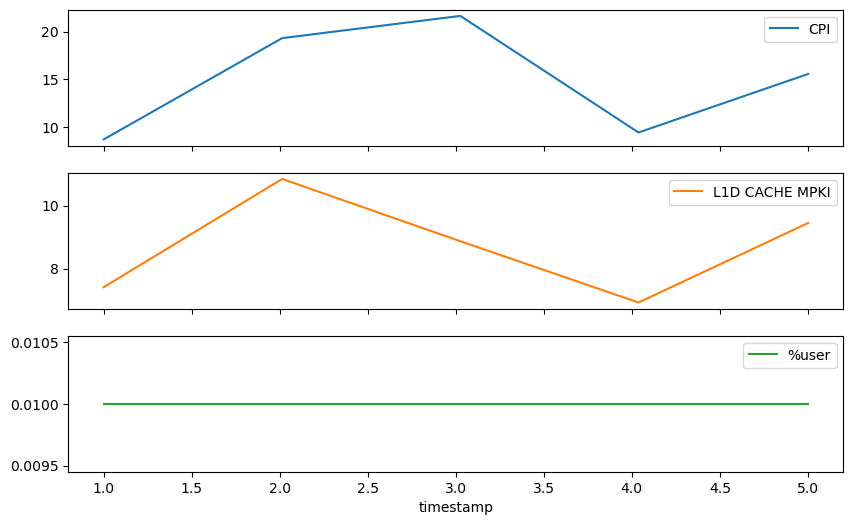

In [96]:
timeseries.plot(x="timestamp", y=["CPI", "L1D CACHE MPKI", r"%user"], subplots=True, figsize=(10, 6))